In [61]:
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import sklearn
import sklearn.cluster
import matplotlib.pyplot as plt
import skimage
import tqdm
import pyefd

import seed_detector.tools as sdt
from seed_detector.tools import resample_polygon, polygon_area, get_contours
def reset_starting_point(contour):
    best_i = 0
    best_d = np.inf
    mid_x = (contour[:, 1].max() - contour[:, 1].min()) / 2 + contour[:, 1].min()
    mid_y = (contour[:, 0].max() - contour[:, 0].min()) / 2 + contour[:, 0].min()
    for i in range(contour.shape[0]):
        d = np.abs(contour[i, 1] - mid_x)
        if d < best_d and contour[i, 0] < mid_y:
            best_d = d
            best_i = i
    return np.r_[contour[best_i:, ], contour[:best_i, ]]

In [62]:
test_dir = './test_align/'
contour_files = list(Path(test_dir).rglob('*/contours/*.csv'))

contours = []
for mask_file in tqdm.tqdm(contour_files):
    contour = pd.read_csv(mask_file).values
    # set first contour point to lower middle
    contour = reset_starting_point(contour)
    # resample contour to 50 points
    contour = resample_polygon(contour, 50)
    # "standardize" contour (for size invariance)
    contour = (contour - contour.mean(0)) / contour[:, 1].max()

    contours.append(contour)

100%|██████████| 7268/7268 [00:19<00:00, 378.00it/s]


In [63]:
# test_dir = './test_align/'
# mask_files = list(Path(test_dir).rglob('*/masks/*.png'))

# contours = []
# for mask_file in tqdm.tqdm(mask_files):
#     mask = cv2.imread(str(mask_file), cv2.IMREAD_UNCHANGED)
#     c = get_contours(mask, 1)
#     if len(c) < 1:
#         print(f'Could not find contour in {mask_file}.')
#         continue
    
#     # get largest contour (it is possible that small contours are introduced by aligning the images)
#     contour = sorted(c, key=lambda c: c.shape[0])[0]
#     # set first contour point to lower middle
#     contour = reset_starting_point(contour)
#     # resample contour to 50 points
#     contour = resample_polygon(contour, 50)
#     # "standardize" contour (for size invariance)
#     contour = (contour - contour.mean(0)) / contour[:, 0].max()
#     # 2D -> 1D (x1,y1,x2,y2,...,xn,yn)
# #     contour = contour.ravel()

#     contours.append(contour)

In [64]:
import warnings
warnings.filterwarnings("error")

coeffs = []
for c in tqdm.tqdm(contours):
    try:
        coeffs.append(pyefd.elliptic_fourier_descriptors(c, order=5))
    except RuntimeWarning as w:
        print(w)
x = np.array([c.ravel() for c in tqdm.tqdm(coeffs)])
pca = sklearn.decomposition.PCA(10)
pca.fit(x)
r = pca.transform(x)

100%|██████████| 7268/7268 [00:00<00:00, 1612920.71it/s]


In [65]:
# K-Means
k=20

km = sklearn.cluster.KMeans(n_clusters=k)
km.fit(r)
cl = km.predict(r)

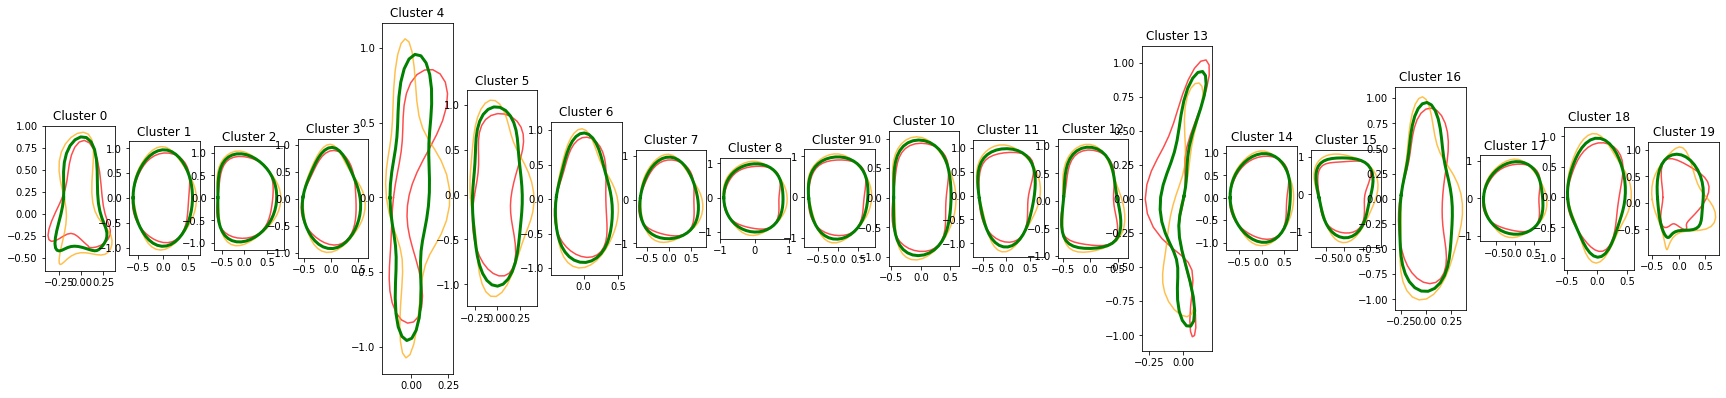

In [66]:
fig, axs = plt.subplots(1, k, figsize=[30, 7])
for i in range(k):
    r_tmp = r[cl == i,:]
#     m = pca.inverse_transform(r_tmp.mean(axis=0)).reshape(-1, 2)
    m = pyefd.reconstruct_contour(pca.inverse_transform(r_tmp.mean(axis=0)).reshape(-1, 4), num_points=50)
    axs[i].plot(m[:, 0], m[:, 1], color='green', zorder=10, linewidth=3)
    
    # plot mean +- sd in PC-space (visualizes cluster homogeneity)
#     m_u = pca.inverse_transform(r_tmp.mean(axis=0) + r_tmp.std(axis=0)).reshape(-1, 2)
    m_u = pyefd.reconstruct_contour(pca.inverse_transform(r_tmp.mean(axis=0) + r_tmp.std(axis=0)).reshape(-1, 4), num_points=50)
#     m_l = pca.inverse_transform(r_tmp.mean(axis=0) - r_tmp.std(axis=0)).reshape(-1, 2)
    m_l = pyefd.reconstruct_contour(pca.inverse_transform(r_tmp.mean(axis=0) - r_tmp.std(axis=0)).reshape(-1, 4), num_points=50)
    axs[i].plot(m_u[:, 0], m_u[:, 1], color='red', alpha=0.7)
    axs[i].plot(m_l[:, 0], m_l[:, 1], color='orange', alpha=0.7)
    axs[i].set_aspect('equal')
    axs[i].set_title(f'Cluster {i}')

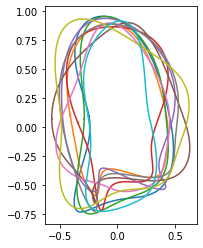

In [70]:
# inspect one cluster (plots 20 randomly drawn contours from a cluster)
test_cluster = 19
r_tmp = r[cl == test_cluster,]
r_idcs = np.random.choice(np.arange(r_tmp.shape[0]), size=10)
for c in r_tmp[r_idcs, :]:
#     yx = pca.inverse_transform(c).reshape(-1, 2)
    yx = pyefd.reconstruct_contour(pca.inverse_transform(c).reshape(-1, 4))
    plt.plot(yx[:, 0], yx[:, 1])
plt.gca().set_aspect('equal')